In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv("./archive (4)/UrbanSound8K.csv")
df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [7]:
import os
import librosa
import librosa.display

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [9]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [10]:
# Audio Playback (Optional)
import IPython.display as ipd

# Resampling Library
import resampy  

from tqdm.auto import tqdm

In [11]:
dat1, sampling_rate1 = librosa.load('./archive (4)/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('./archive (4)/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

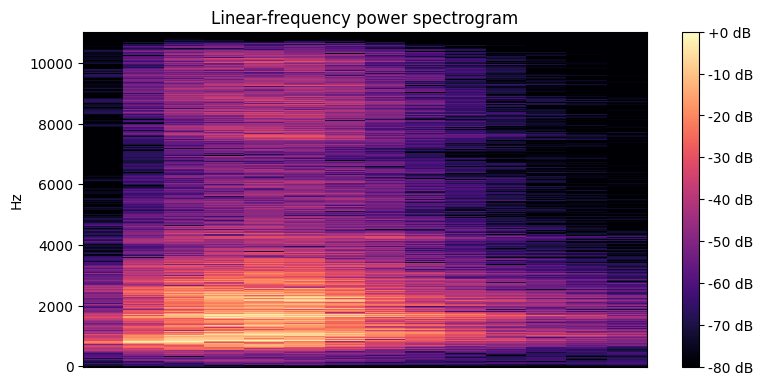

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Register Matplotlib Converters for Time Series Plots
pd.plotting.register_matplotlib_converters()
%matplotlib inline  
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

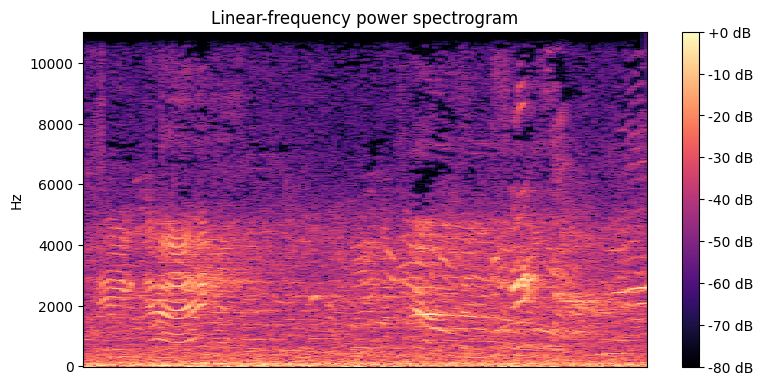

In [13]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

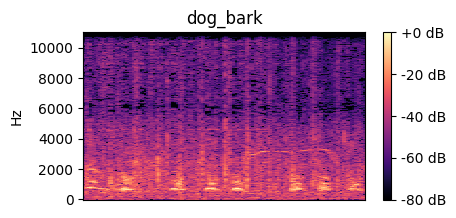

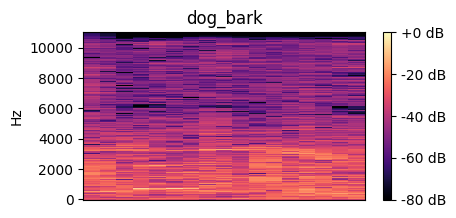

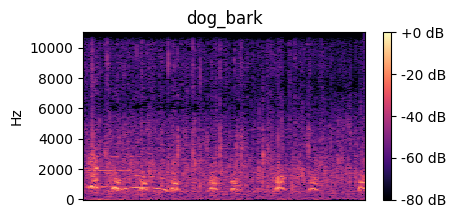

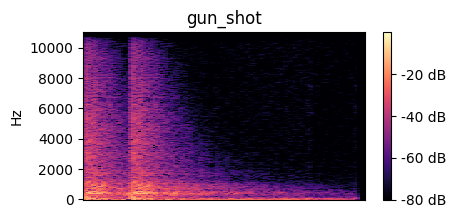

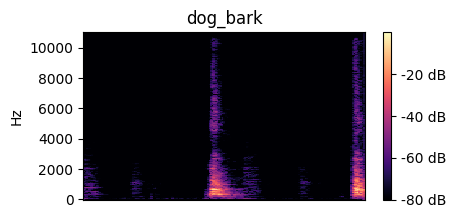

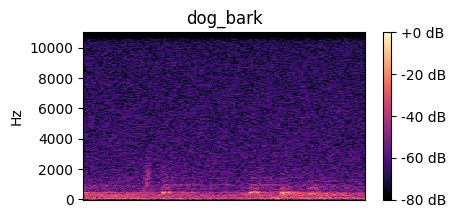

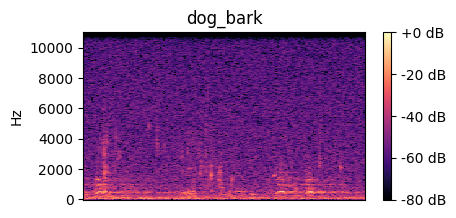

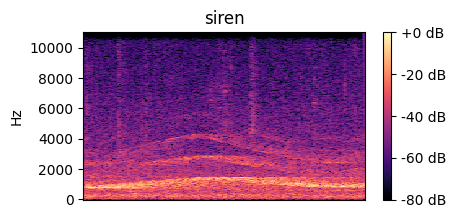

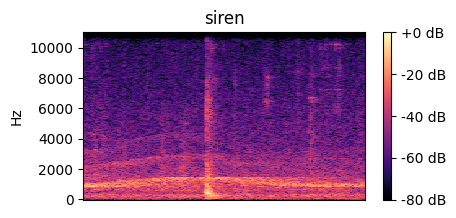

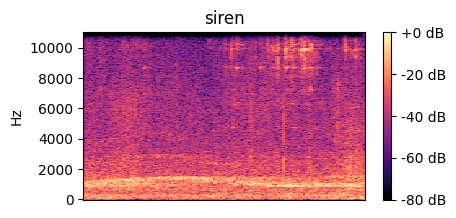

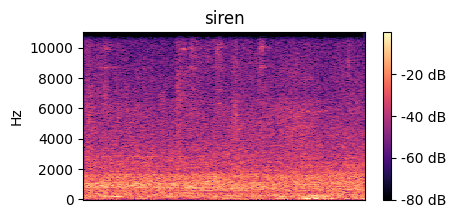

In [14]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(100, 121, 2):
    path = './archive (4)/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [15]:
# First restart kernel 
print("Librosa version:", librosa.__version__)
print("Resampy version:", resampy.__version__)

Librosa version: 0.10.2.post1
Resampy version: 0.4.3


In [16]:
def features_extract(file_name):
    sample, sample_rate = librosa.load(file_name, sr=None) 
    feature = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=50, n_fft=1024)
    scaled_feature = np.mean(feature.T, axis=0)
    return scaled_feature

extracted = []
path = './archive (4)'

for index_num, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path), 'fold' + str(row["fold"]), str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data = features_extract(file_name)    
    extracted.append([data, final_class_labels])


0it [00:00, ?it/s]

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [17]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

feature             class
0     [-351.31757, 117.981636, -95.81988, -65.53432,...          dog_bark
1     [-573.2332, 183.8388, -86.40056, 48.547085, 9....  children_playing
2     [-604.575, 186.74057, -71.29498, 40.730904, 8....  children_playing
3     [-548.593, 160.9375, -62.202946, 50.249115, 0....  children_playing
4     [-594.21716, 183.91356, -82.14957, 45.883015, ...  children_playing
...                                                 ...               ...
8727  [-538.649, 191.99374, -64.07638, 29.174511, -9...          car_horn
8728  [-468.83472, 132.39731, -63.712795, 41.505905,...          car_horn
8729  [-434.77618, 167.4113, -62.00018, 30.774382, -...          car_horn
8730  [-476.32877, 178.94542, -63.6594, 25.602303, -...          car_horn
8731  [-440.5, 148.26161, -64.129776, 46.808952, -9....          car_horn

[8732 rows x 2 columns]

In [18]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [19]:
def showAccVallLossPlt(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

CNN

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

num_labels = y.shape[1]
modelConv = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),  

    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),

    Flatten(),  

    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(num_labels, activation='softmax')  
])

modelConv.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 48, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 22, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 9, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,010 (1000.04 KB)

 Trainable params: 256,010 (1000.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2797 - loss: 2.2631 - val_accuracy: 0.5781 - val_loss: 1.2930
Epoch 2/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5393 - loss: 1.3710 - val_accuracy: 0.6760 - val_loss: 0.9977
Epoch 3/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6636 - loss: 1.0189 - val_accuracy: 0.7722 - val_loss: 0.6937
Epoch 4/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7429 - loss: 0.7748 - val_accuracy: 0.8134 - val_loss: 0.6026
Epoch 5/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7948 - loss: 0.6129 - val_accuracy: 0.8437 - val_loss: 0.5129
Epoch 6/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8329 - loss: 0.5255 - val_accuracy: 0.8523 - val_loss: 0.4659
Epoch 7/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8607 - loss: 0.4201 - val_accuracy: 0.8678 - val_loss: 0.4160
Epoch 8/180
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8866 - loss: 0.3483 - val_ac

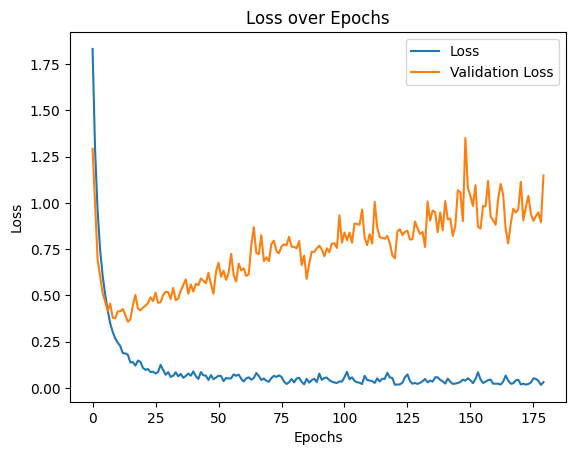

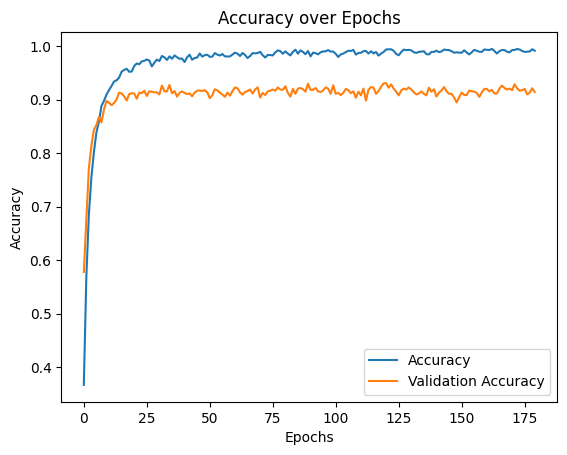

In [23]:
modelConv.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history4 = modelConv.fit(
          x_train, 
          y_train, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history4)

In [24]:
from tensorflow.keras.layers import BatchNormalization

num_labels = y.shape[1]
modelConv2 = Sequential([
    Input(shape=(50, 1)), 
    
    Conv1D(64, 3, activation='relu'), 
    MaxPooling1D(2),
    BatchNormalization(),  #
    
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(256, 3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256, activation='relu'),  
    Dropout(0.5),
    Dense(128, activation='relu'),  
    Dropout(0.5),
    
    Dense(num_labels, activation='softmax')
])

modelConv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelConv2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 48, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 22, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 11, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 9, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,898 (1.61 MB)

 Trainable params: 421,002 (1.61 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2720 - loss: 2.2286 - val_accuracy: 0.5157 - val_loss: 1.5735
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5254 - loss: 1.3861 - val_accuracy: 0.7178 - val_loss: 0.9408
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6558 - loss: 1.0527 - val_accuracy: 0.7155 - val_loss: 0.8772
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7197 - loss: 0.8502 - val_accuracy: 0.8065 - val_loss: 0.5801
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7645 - loss: 0.7280 - val_accuracy: 0.8105 - val_loss: 0.5855
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7949 - loss: 0.6374 - val_accuracy: 0.8248 - val_loss: 0.5450
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8323 - loss: 0.5221 - val_accuracy: 0.8678 - val_loss: 0.4269
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8612 - loss: 0.4308 - val_accu

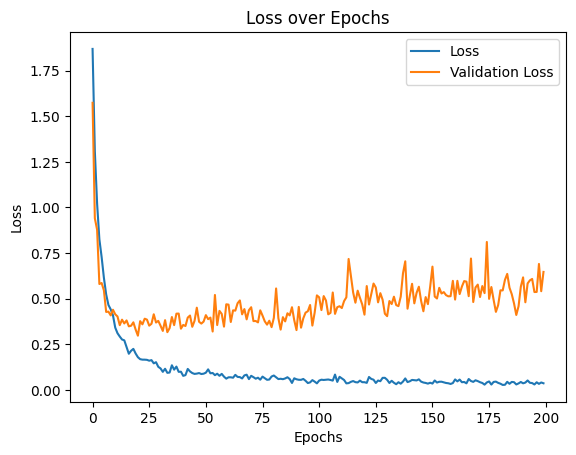

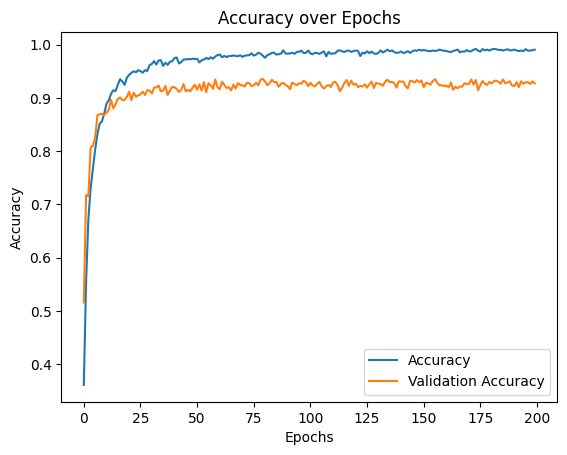

In [26]:
history6 = modelConv2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32)
showAccVallLossPlt(history6)

In [30]:
def extract_feature(file_name):
    audio_data, sample_rate = librosa.load(file_name, sr=22050, res_type='soxr_vhq')  # Avoids resampy
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T, axis=0)
    return np.array([scaled])

def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(modelConv2.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [31]:
df

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

In [36]:
print_prediction('./archive (4)/fold10/102857-5-0-12.wav')
ipd.Audio('./archive (4)/fold10/102857-5-0-12.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The predicted class is: engine_idling 



In [38]:
print_prediction('./archive (4)/fold7/104625-4-0-3.wav')
ipd.Audio('./archive (4)/fold7/104625-4-0-3.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The predicted class is: drilling 



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


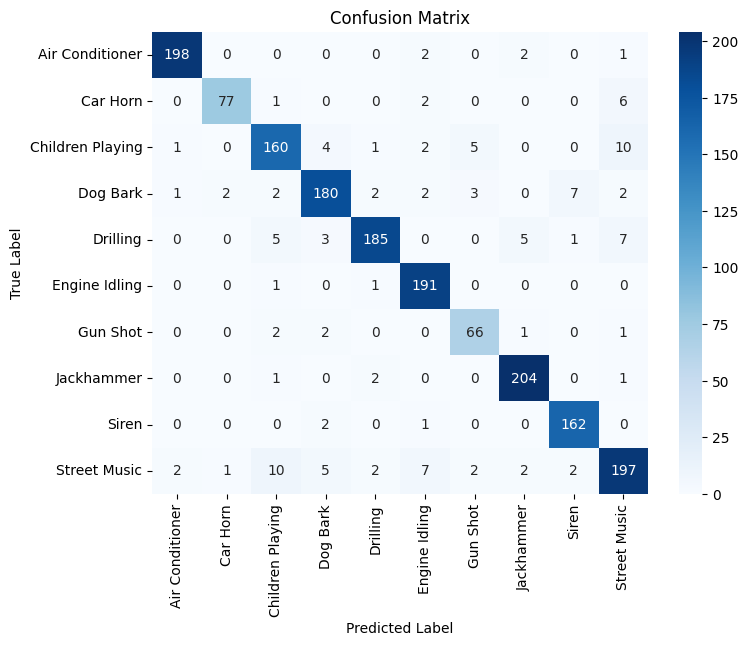

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       203
           1       0.96      0.90      0.93        86
           2       0.88      0.87      0.88       183
           3       0.92      0.90      0.91       201
           4       0.96      0.90      0.93       206
           5       0.92      0.99      0.95       193
           6       0.87      0.92      0.89        72
           7       0.95      0.98      0.97       208
           8       0.94      0.98      0.96       165
           9       0.88      0.86      0.87       230

    accuracy                           0.93      1747
   macro avg       0.93      0.93      0.93      1747
weighted avg       0.93      0.93      0.93      1747



In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
class_labels = [
    "Air Conditioner",  # 0
    "Car Horn",         # 1
    "Children Playing", # 2
    "Dog Bark",         # 3
    "Drilling",         # 4
    "Engine Idling",    # 5
    "Gun Shot",         # 6
    "Jackhammer",       # 7
    "Siren",            # 8
    "Street Music"      # 9
]

y_pred_probs = modelConv2.predict(x_test)  
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))


In [40]:
# Overall Accuracy
y_pred = modelConv2.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, and F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9273
Classification Report:
                   precision    recall  f1-score   support

 Air Conditioner       0.98      0.98      0.98       203
        Car Horn       0.96      0.90      0.93        86
Children Playing       0.88      0.87      0.88       183
        Dog Bark       0.92      0.90      0.91       201
        Drilling       0.96      0.90      0.93       206
   Engine Idling       0.92      0.99      0.95       193
        Gun Shot       0.87      0.92      0.89        72
      Jackhammer       0.95      0.98      0.97       208
           Siren       0.94      0.98      0.96       165
    Street Music       0.88      0.86      0.87       230

        accuracy                           0.93      1747
       macro avg       0.93      0.93      0.93      1747
    weighted avg       0.93      0.93      0.93      1747

